### Evaluating performance and drift of mortality decompensation model (LSTM) using a rolling window

In [ ]:
import datetime
import os
import random
import scipy.stats
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr, spearmanr
import pickle
from alibi_detect.cd.pytorch import HiddenOutput

from cyclops.utils.file import load_pickle, save_pickle

from cyclops.processors.column_names import (
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    ENCOUNTER_ID,
    EVENT_NAME,
    EVENT_TIMESTAMP,
    EVENT_VALUE,
    RESTRICT_TIMESTAMP,
    TIMESTEP,
)

from drift_detection.drift_detector.clinical_applicator import ClinicalShiftApplicator
from drift_detection.drift_detector.detector import Detector
from drift_detection.drift_detector.experimenter import Experimenter
from drift_detection.drift_detector.plotter import plot_drift_samples_pval
from drift_detection.drift_detector.reductor import Reductor
from drift_detection.drift_detector.tester import DCTester, TSTester
from drift_detection.gemini.constants import DIAGNOSIS_DICT, ACADEMIC, COMMUNITY, HOSPITALS
from drift_detection.gemini.utils import get_use_case_params, impute, prep, import_dataset_hospital
from models.temporal.utils import (
    get_device,
    load_checkpoint,
)
from cyclops.processors.constants import ALL, FEATURES, MEAN, NUMERIC, ORDINAL, STANDARD
from cyclops.processors.feature.vectorize import (
    Vectorized,
    intersect_vectorized,
    split_vectorized,
    vec_index_exp,
)
from drift_detection.drift_detector.rolling_window import RollingWindow
from drift_detection.drift_detector.utils import get_serving_data, get_temporal_model

In [2]:
DATASET = "gemini"
USE_CASE = "mortality"
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/"
TIMESTEPS = 6
AGGREGATION_TYPE = "time"   
ID = SHIFT = input("Select data split: ")
DIAGNOSIS_TRAJECTORY = input("Select diagnosis trajectory to filter on: ") 
HOSPITAL = input("Select hospital to filter on: ") 

splice_map = {
    "hospital_id": HOSPITALS
}

if DIAGNOSIS_TRAJECTORY != "all":
    diagnosis_trajectory = '_'.join(DIAGNOSIS_DICT[DIAGNOSIS_TRAJECTORY])
    ID = ID +"_"+ diagnosis_trajectory
    splice_map["diagnosis_trajectory"] = [diagnosis_trajectory]
    
if HOSPITAL != "all":
    ID = HOSPITAL + "_" + ID 
    splice_map["hospital_id"] = [HOSPITAL]
    
use_case_params = get_use_case_params(DATASET, USE_CASE)
    
MODEL_PATH = os.path.join(
    PATH,
    DATASET,
    USE_CASE,
    "saved_models",
    "simulated_deployment_reweight_positive_lstm_1.pt"
)

Select data split:  simulated_deployment
Select diagnosis trajectory to filter on:  all
Select hospital to filter on:  all


## Get data

In [3]:
random.seed(1)

tab_features = load_pickle(use_case_params.TAB_FEATURES_FILE)

use_case_params = get_use_case_params(DATASET, USE_CASE)

(X_tr_final, y_tr), (X_val_final, y_val), (X_t_final, y_t) = import_dataset_hospital(
    use_case_params.TAB_VEC_COMB, ID, train_frac=0.8, shuffle=True,
)

2023-01-29 13:25:08,163 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/tab_features.pkl
2023-01-29 13:25:08,368 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_simulated_deployment.pkl
2023-01-29 13:25:08,811 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_simulated_deployment.pkl
2023-01-29 13:25:08,865 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_simulated_deployment.pkl
2023-01-29 13:25:08,990 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_simulated_deployment.pkl
2023-01-29 13:25:09,003 INFO cy

## Create data streams

In [4]:
START_DATE = date(2019, 1, 1)
END_DATE = date(2020, 8, 1)

In [5]:
print("Get target data streams...")
data_streams_filepath = os.path.join(
    PATH,
    DATASET,
    USE_CASE,
    "drift",
    "data_streams_"+ID+"_"+str(START_DATE)+"_"+str(END_DATE)+".pkl"
)
data_streams_filepath

if os.path.exists(data_streams_filepath):
    data_streams = load_pickle(data_streams_filepath)
else:
    tab_vectorized = load_pickle(use_case_params.TAB_VECTORIZED_FILE)
    comb_vectorized = load_pickle(use_case_params.COMB_VECTORIZED_FILE)


    ids = tab_features.slice(splice_map)
    tab_vectorized = tab_vectorized.take_with_index(ENCOUNTER_ID, ids)
    # intersect tabular and temporal vectors of source data
    tab_vectorized, comb_vectorized = intersect_vectorized(
        [tab_vectorized, comb_vectorized], axes=ENCOUNTER_ID
    )
    numeric_features = tab_features.features_by_type(NUMERIC)    
    normalizer_map = {feat: STANDARD for feat in numeric_features}
    comb_vectorized.add_normalizer(
        EVENT_NAME,
        normalization_method=STANDARD,
    )
    X, y = comb_vectorized.split_out(EVENT_NAME, use_case_params.TEMP_TARGETS)
    X = impute(X)
    X.fit_normalizer()
    #X.normalizer = load_pickle("/mnt/nfs/home/subasriv/cyclops/drift_detection/notebooks/mortality/normalizer.pkl")
    X.normalize()

    X_final = prep(X)
    ind = pd.MultiIndex.from_product(
            [X.indexes[1], range(6)], names=[ENCOUNTER_ID, TIMESTEP]
    )
    X_final = pd.DataFrame(X_final.reshape(X_final.shape[0]*X_final.shape[1], X_final.shape[2]),index=ind, columns=X.indexes[2])
    y_final = y.data.reshape(y.data.shape[1],y.data.shape[3])

    data_streams = get_serving_data(
        X_final,
        y_final,
        tab_features.data,
        START_DATE,
        END_DATE,
        stride=1,
        window=1,
        encounter_id="encounter_id",
        admit_timestamp="admit_timestamp",
    )
    save_pickle(data_streams, data_streams_filepath)

2023-01-29 13:25:10,712 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/data_streams_simulated_deployment_2019-01-01_2020-08-01.pkl


Get target data streams...


## Get prediction model

In [6]:
output_dim = 1
input_dim = X_tr_final.shape[2]
hidden_dim = 64
layer_dim = 2
dropout = 0.2
last_timestep_only = False
device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
model, optimizer, n_epochs = load_checkpoint(MODEL_PATH, model)
#model = HiddenOutput(model, layer=-1)

## Get shift detector

In [13]:
DR_TECHNIQUE = "BBSDs_trained_LSTM"
TESTER_METHOD = "ks"
THRESHOLD = 0.01
UPDATE_REF = 25000

print("Get Shift Reductor...")
reductor = Reductor(
    dr_method=DR_TECHNIQUE,
    model_path=MODEL_PATH,
    n_features=X_tr_final.shape[2],
    var_ret=0.8,
)

tstesters=["lk", "lsdd", "mmd", "tabular", "ctx_mmd","chi2", "fet", "ks" ]
dctesters =["spot_the_diff", "classifier", "classifier_uncertainty"]
CONTEXT_TYPE=None
REPRESENTATION=None

if TESTER_METHOD in tstesters:
    tester = TSTester(
        tester_method=TESTER_METHOD,
    ) 
    if TESTER_METHOD == "ctx_mmd":
        CONTEXT_TYPE = input("Select context type: ")
        
elif TESTER_METHOD in dctesters:
    MODEL_METHOD = input("Select model method: ")
    tester = DCTester(
        tester_method=TESTER_METHOD,
        model_method=MODEL_METHOD,
    )
        
    if TESTER_METHOD == "lk":
        REPRESENTATION = input("Select learned kernel representation: ")
else:
    print("Tester method invalid or not supported.")
    
print("Get Shift Detector...")
detector = Detector(
    reductor=reductor,
    tester=tester
)

detector.fit(
    X_val_final,
    backend="pytorch",
    device = "cuda",
    model_path = MODEL_PATH,
    batch_size=32,
    verbose=0,
    alternative="greater",
    correction="bonferroni",
    input_dim=X_tr_final.shape[2],
    update_x_ref={'last': UPDATE_REF}
)

Get Shift Reductor...
Loading model...
Get Shift Detector...


In [14]:
print("Get Rolling Window...")

SAMPLE = 1000
STAT_WINDOW = 14
LOOKUP_WINDOW = 0
STRIDE = 1

rolling_window = RollingWindow(
    admin_data=tab_features.data, shift_detector=detector, optimizer=optimizer
)

Get Rolling Window...


In [15]:
all_runs = []
for i in range(0, 5):
    random.seed(i)
    np.random.seed(i)

    drift_metrics = rolling_window.drift(
        data_streams=data_streams,
        sample=SAMPLE,
        stat_window=STAT_WINDOW,
        lookup_window=LOOKUP_WINDOW,
        stride=STRIDE,
        model_path=MODEL_PATH,
        threshold=THRESHOLD,
        verbose=1,
        randomize=0,
    )

    performance_metrics = rolling_window.performance(
        data_streams=data_streams,
        stat_window=STAT_WINDOW,
        lookup_window=LOOKUP_WINDOW,
        stride=STRIDE,
    )

    results = {
        "timestamps": [
            (
                datetime.datetime.strptime(date, "%Y-%m-%d")
                + datetime.timedelta(days=LOOKUP_WINDOW + STAT_WINDOW)
            ).strftime("%Y-%m-%d")
            for date in data_streams["timestamps"]
        ][:-STAT_WINDOW]
    }
    results.update(drift_metrics)
    results.update(performance_metrics)

    all_runs.append(results)
    
path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+"_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
save_pickle(all_runs, path)


  0%|          | 0/534 [00:00<?, ?it/s]

P-value below threshold for  2019-01-02 - 2019-01-16 	P-Value:  2.4476e-41
P-value below threshold for  2019-01-03 - 2019-01-17 	P-Value:  1.2064633e-38
P-value below threshold for  2019-01-04 - 2019-01-18 	P-Value:  2.7585033e-36
P-value below threshold for  2019-01-05 - 2019-01-19 	P-Value:  1.751496e-33
P-value below threshold for  2019-01-06 - 2019-01-20 	P-Value:  9.070867e-31
P-value below threshold for  2019-01-07 - 2019-01-21 	P-Value:  1.03215875e-29
P-value below threshold for  2019-01-08 - 2019-01-22 	P-Value:  4.0279436e-28
P-value below threshold for  2019-01-09 - 2019-01-23 	P-Value:  2.3400627e-26
P-value below threshold for  2019-01-10 - 2019-01-24 	P-Value:  2.6111935e-24
P-value below threshold for  2019-01-11 - 2019-01-25 	P-Value:  4.9269665e-24
P-value below threshold for  2019-01-12 - 2019-01-26 	P-Value:  8.902866e-22
P-value below threshold for  2019-01-13 - 2019-01-27 	P-Value:  3.4399128e-19
P-value below threshold for  2019-01-14 - 2019-01-28 	P-Value:  9.501


  9%|▉         | 50/534 [00:17<02:49,  2.86it/s]

P-value below threshold for  2019-02-01 - 2019-02-15 	P-Value:  0.008227839
P-value below threshold for  2019-02-02 - 2019-02-16 	P-Value:  0.003462739
P-value below threshold for  2019-02-03 - 2019-02-17 	P-Value:  0.0032917096
P-value below threshold for  2019-02-04 - 2019-02-18 	P-Value:  0.0040812446



 28%|██▊       | 150/534 [00:54<02:28,  2.59it/s]

P-value below threshold for  2019-05-25 - 2019-06-08 	P-Value:  0.009921345
P-value below threshold for  2019-05-27 - 2019-06-10 	P-Value:  0.008801448



 37%|███▋      | 200/534 [01:23<02:33,  2.17it/s]

P-value below threshold for  2019-06-09 - 2019-06-23 	P-Value:  0.006560307
P-value below threshold for  2019-06-10 - 2019-06-24 	P-Value:  0.0016684922
P-value below threshold for  2019-06-11 - 2019-06-25 	P-Value:  0.0018433122
P-value below threshold for  2019-06-12 - 2019-06-26 	P-Value:  0.0037177012
P-value below threshold for  2019-06-13 - 2019-06-27 	P-Value:  0.004667381
P-value below threshold for  2019-06-14 - 2019-06-28 	P-Value:  0.0014848278
P-value below threshold for  2019-06-15 - 2019-06-29 	P-Value:  0.0014073184
P-value below threshold for  2019-06-16 - 2019-06-30 	P-Value:  0.0019660234
P-value below threshold for  2019-06-18 - 2019-07-02 	P-Value:  0.007922878
P-value below threshold for  2019-06-20 - 2019-07-04 	P-Value:  0.0050049117
P-value below threshold for  2019-06-21 - 2019-07-05 	P-Value:  0.005589442
P-value below threshold for  2019-07-06 - 2019-07-20 	P-Value:  0.006516646
P-value below threshold for  2019-07-07 - 2019-07-21 	P-Value:  0.0084417835



 47%|████▋     | 250/534 [01:51<02:20,  2.03it/s]

P-value below threshold for  2019-08-25 - 2019-09-08 	P-Value:  0.0071850847
P-value below threshold for  2019-08-26 - 2019-09-09 	P-Value:  0.004756616
P-value below threshold for  2019-08-27 - 2019-09-10 	P-Value:  0.009848008
P-value below threshold for  2019-08-28 - 2019-09-11 	P-Value:  0.002352346
P-value below threshold for  2019-08-29 - 2019-09-12 	P-Value:  0.00017182333
P-value below threshold for  2019-08-30 - 2019-09-13 	P-Value:  0.0009290971
P-value below threshold for  2019-08-31 - 2019-09-14 	P-Value:  0.0005668868
P-value below threshold for  2019-09-01 - 2019-09-15 	P-Value:  0.00023614665
P-value below threshold for  2019-09-02 - 2019-09-16 	P-Value:  0.00032132195
P-value below threshold for  2019-09-03 - 2019-09-17 	P-Value:  0.00010059768
P-value below threshold for  2019-09-04 - 2019-09-18 	P-Value:  0.0005564708
P-value below threshold for  2019-09-05 - 2019-09-19 	P-Value:  0.00029399197
P-value below threshold for  2019-09-06 - 2019-09-20 	P-Value:  0.00054568


 56%|█████▌    | 300/534 [02:20<02:02,  1.91it/s]

P-value below threshold for  2019-09-08 - 2019-09-22 	P-Value:  0.0007438236
P-value below threshold for  2019-09-09 - 2019-09-23 	P-Value:  0.0013529969
P-value below threshold for  2019-09-10 - 2019-09-24 	P-Value:  0.008009266
P-value below threshold for  2019-10-25 - 2019-11-08 	P-Value:  0.007678277



 66%|██████▌   | 350/534 [02:51<01:41,  1.81it/s]

P-value below threshold for  2019-11-02 - 2019-11-16 	P-Value:  0.0018104023
P-value below threshold for  2019-11-03 - 2019-11-17 	P-Value:  0.0049197683
P-value below threshold for  2019-11-04 - 2019-11-18 	P-Value:  0.005078636
P-value below threshold for  2019-11-05 - 2019-11-19 	P-Value:  0.0010173373
P-value below threshold for  2019-11-06 - 2019-11-20 	P-Value:  0.0033011166
P-value below threshold for  2019-11-07 - 2019-11-21 	P-Value:  0.0055192746
P-value below threshold for  2019-11-08 - 2019-11-22 	P-Value:  0.002964354
P-value below threshold for  2019-11-09 - 2019-11-23 	P-Value:  0.005142145
P-value below threshold for  2019-12-02 - 2019-12-16 	P-Value:  0.009760996



 84%|████████▍ | 450/534 [04:03<00:53,  1.56it/s]

P-value below threshold for  2020-02-10 - 2020-02-24 	P-Value:  0.009000263
P-value below threshold for  2020-02-11 - 2020-02-25 	P-Value:  0.004397038
P-value below threshold for  2020-02-12 - 2020-02-26 	P-Value:  0.009881742
P-value below threshold for  2020-02-14 - 2020-02-28 	P-Value:  0.0037504053
P-value below threshold for  2020-02-15 - 2020-02-29 	P-Value:  0.00782484
P-value below threshold for  2020-02-18 - 2020-03-03 	P-Value:  0.009626038
P-value below threshold for  2020-02-19 - 2020-03-04 	P-Value:  0.0064901556
P-value below threshold for  2020-03-16 - 2020-03-30 	P-Value:  0.00334569
P-value below threshold for  2020-03-17 - 2020-03-31 	P-Value:  0.002773774
P-value below threshold for  2020-03-18 - 2020-04-01 	P-Value:  0.0049688765
P-value below threshold for  2020-03-19 - 2020-04-02 	P-Value:  0.0021967404
P-value below threshold for  2020-03-20 - 2020-04-03 	P-Value:  0.00085388403
P-value below threshold for  2020-03-21 - 2020-04-04 	P-Value:  0.00042574093
P-valu


 94%|█████████▎| 500/534 [04:35<00:21,  1.56it/s]

P-value below threshold for  2020-03-26 - 2020-04-09 	P-Value:  0.002526558



550it [05:06,  1.57it/s]                         

P-value below threshold for  2020-05-30 - 2020-06-13 	P-Value:  0.0062679895
P-value below threshold for  2020-05-31 - 2020-06-14 	P-Value:  0.008596979
P-value below threshold for  2020-06-01 - 2020-06-15 	P-Value:  0.00831358


550it [05:28,  1.67it/s]

 94%|█████████▎| 500/534 [06:39<00:31,  1.09it/s]
550it [07:40,  1.20it/s]                         

 28%|██▊       | 150/534 [00:41<01:51,  3.44it/s]

P-value below threshold for  2019-05-25 - 2019-06-08 	P-Value:  0.009921345
P-value below threshold for  2019-05-27 - 2019-06-10 	P-Value:  0.008801448



 37%|███▋      | 200/534 [01:03<01:56,  2.86it/s]

P-value below threshold for  2019-06-09 - 2019-06-23 	P-Value:  0.006560307
P-value below threshold for  2019-06-10 - 2019-06-24 	P-Value:  0.0016684922
P-value below threshold for  2019-06-11 - 2019-06-25 	P-Value:  0.0018433122
P-value below threshold for  2019-06-12 - 2019-06-26 	P-Value:  0.0037177012
P-value below threshold for  2019-06-13 - 2019-06-27 	P-Value:  0.004667381
P-value below threshold for  2019-06-14 - 2019-06-28 	P-Value:  0.0014848278
P-value below threshold for  2019-06-15 - 2019-06-29 	P-Value:  0.0014073184
P-value below threshold for  2019-06-16 - 2019-06-30 	P-Value:  0.0019660234
P-value below threshold for  2019-06-18 - 2019-07-02 	P-Value:  0.007922878
P-value below threshold for  2019-06-20 - 2019-07-04 	P-Value:  0.0050049117
P-value below threshold for  2019-06-21 - 2019-07-05 	P-Value:  0.005589442
P-value below threshold for  2019-07-06 - 2019-07-20 	P-Value:  0.006516646
P-value below threshold for  2019-07-07 - 2019-07-21 	P-Value:  0.0084417835



 47%|████▋     | 250/534 [01:25<01:47,  2.64it/s]

P-value below threshold for  2019-08-25 - 2019-09-08 	P-Value:  0.0071850847
P-value below threshold for  2019-08-26 - 2019-09-09 	P-Value:  0.004756616
P-value below threshold for  2019-08-27 - 2019-09-10 	P-Value:  0.009848008
P-value below threshold for  2019-08-28 - 2019-09-11 	P-Value:  0.002352346
P-value below threshold for  2019-08-29 - 2019-09-12 	P-Value:  0.00017182333
P-value below threshold for  2019-08-30 - 2019-09-13 	P-Value:  0.0009290971
P-value below threshold for  2019-08-31 - 2019-09-14 	P-Value:  0.0005668868
P-value below threshold for  2019-09-01 - 2019-09-15 	P-Value:  0.00023614665
P-value below threshold for  2019-09-02 - 2019-09-16 	P-Value:  0.00032132195
P-value below threshold for  2019-09-03 - 2019-09-17 	P-Value:  0.00010059768
P-value below threshold for  2019-09-04 - 2019-09-18 	P-Value:  0.0005564708
P-value below threshold for  2019-09-05 - 2019-09-19 	P-Value:  0.00029399197
P-value below threshold for  2019-09-06 - 2019-09-20 	P-Value:  0.00054568


 56%|█████▌    | 300/534 [01:47<01:33,  2.50it/s]

P-value below threshold for  2019-09-08 - 2019-09-22 	P-Value:  0.0007438236
P-value below threshold for  2019-09-09 - 2019-09-23 	P-Value:  0.0013529969
P-value below threshold for  2019-09-10 - 2019-09-24 	P-Value:  0.008009266
P-value below threshold for  2019-10-25 - 2019-11-08 	P-Value:  0.007678277



 66%|██████▌   | 350/534 [02:10<01:16,  2.40it/s]

P-value below threshold for  2019-11-02 - 2019-11-16 	P-Value:  0.0018104023
P-value below threshold for  2019-11-03 - 2019-11-17 	P-Value:  0.0049197683
P-value below threshold for  2019-11-04 - 2019-11-18 	P-Value:  0.005078636
P-value below threshold for  2019-11-05 - 2019-11-19 	P-Value:  0.0010173373
P-value below threshold for  2019-11-06 - 2019-11-20 	P-Value:  0.0033011166
P-value below threshold for  2019-11-07 - 2019-11-21 	P-Value:  0.0055192746
P-value below threshold for  2019-11-08 - 2019-11-22 	P-Value:  0.002964354
P-value below threshold for  2019-11-09 - 2019-11-23 	P-Value:  0.005142145
P-value below threshold for  2019-12-02 - 2019-12-16 	P-Value:  0.009760996



 84%|████████▍ | 450/534 [03:03<00:40,  2.07it/s]

P-value below threshold for  2020-02-10 - 2020-02-24 	P-Value:  0.009000263
P-value below threshold for  2020-02-11 - 2020-02-25 	P-Value:  0.004397038
P-value below threshold for  2020-02-12 - 2020-02-26 	P-Value:  0.009881742
P-value below threshold for  2020-02-14 - 2020-02-28 	P-Value:  0.0037504053
P-value below threshold for  2020-02-15 - 2020-02-29 	P-Value:  0.00782484
P-value below threshold for  2020-02-18 - 2020-03-03 	P-Value:  0.009626038
P-value below threshold for  2020-02-19 - 2020-03-04 	P-Value:  0.0064901556
P-value below threshold for  2020-03-16 - 2020-03-30 	P-Value:  0.00334569
P-value below threshold for  2020-03-17 - 2020-03-31 	P-Value:  0.002773774
P-value below threshold for  2020-03-18 - 2020-04-01 	P-Value:  0.0049688765
P-value below threshold for  2020-03-19 - 2020-04-02 	P-Value:  0.0021967404
P-value below threshold for  2020-03-20 - 2020-04-03 	P-Value:  0.00085388403
P-value below threshold for  2020-03-21 - 2020-04-04 	P-Value:  0.00042574093
P-valu


 94%|█████████▎| 500/534 [03:27<00:16,  2.07it/s]

P-value below threshold for  2020-03-26 - 2020-04-09 	P-Value:  0.002526558



550it [03:50,  2.10it/s]                         

P-value below threshold for  2020-05-30 - 2020-06-13 	P-Value:  0.0062679895
P-value below threshold for  2020-05-31 - 2020-06-14 	P-Value:  0.008596979
P-value below threshold for  2020-06-01 - 2020-06-15 	P-Value:  0.00831358


550it [04:07,  2.23it/s]

 94%|█████████▎| 500/534 [04:38<00:22,  1.54it/s]
550it [05:29,  1.67it/s]                         

 28%|██▊       | 150/534 [00:40<01:49,  3.51it/s]

P-value below threshold for  2019-05-25 - 2019-06-08 	P-Value:  0.009921345
P-value below threshold for  2019-05-27 - 2019-06-10 	P-Value:  0.008801448



 37%|███▋      | 200/534 [01:02<01:54,  2.92it/s]

P-value below threshold for  2019-06-09 - 2019-06-23 	P-Value:  0.006560307
P-value below threshold for  2019-06-10 - 2019-06-24 	P-Value:  0.0016684922
P-value below threshold for  2019-06-11 - 2019-06-25 	P-Value:  0.0018433122
P-value below threshold for  2019-06-12 - 2019-06-26 	P-Value:  0.0037177012
P-value below threshold for  2019-06-13 - 2019-06-27 	P-Value:  0.004667381
P-value below threshold for  2019-06-14 - 2019-06-28 	P-Value:  0.0014848278
P-value below threshold for  2019-06-15 - 2019-06-29 	P-Value:  0.0014073184
P-value below threshold for  2019-06-16 - 2019-06-30 	P-Value:  0.0019660234
P-value below threshold for  2019-06-18 - 2019-07-02 	P-Value:  0.007922878
P-value below threshold for  2019-06-20 - 2019-07-04 	P-Value:  0.0050049117
P-value below threshold for  2019-06-21 - 2019-07-05 	P-Value:  0.005589442
P-value below threshold for  2019-07-06 - 2019-07-20 	P-Value:  0.006516646
P-value below threshold for  2019-07-07 - 2019-07-21 	P-Value:  0.0084417835



 47%|████▋     | 250/534 [01:23<01:45,  2.69it/s]

P-value below threshold for  2019-08-25 - 2019-09-08 	P-Value:  0.0071850847
P-value below threshold for  2019-08-26 - 2019-09-09 	P-Value:  0.004756616
P-value below threshold for  2019-08-27 - 2019-09-10 	P-Value:  0.009848008
P-value below threshold for  2019-08-28 - 2019-09-11 	P-Value:  0.002352346
P-value below threshold for  2019-08-29 - 2019-09-12 	P-Value:  0.00017182333
P-value below threshold for  2019-08-30 - 2019-09-13 	P-Value:  0.0009290971
P-value below threshold for  2019-08-31 - 2019-09-14 	P-Value:  0.0005668868
P-value below threshold for  2019-09-01 - 2019-09-15 	P-Value:  0.00023614665
P-value below threshold for  2019-09-02 - 2019-09-16 	P-Value:  0.00032132195
P-value below threshold for  2019-09-03 - 2019-09-17 	P-Value:  0.00010059768
P-value below threshold for  2019-09-04 - 2019-09-18 	P-Value:  0.0005564708
P-value below threshold for  2019-09-05 - 2019-09-19 	P-Value:  0.00029399197
P-value below threshold for  2019-09-06 - 2019-09-20 	P-Value:  0.00054568


 56%|█████▌    | 300/534 [01:45<01:31,  2.55it/s]

P-value below threshold for  2019-09-08 - 2019-09-22 	P-Value:  0.0007438236
P-value below threshold for  2019-09-09 - 2019-09-23 	P-Value:  0.0013529969
P-value below threshold for  2019-09-10 - 2019-09-24 	P-Value:  0.008009266
P-value below threshold for  2019-10-25 - 2019-11-08 	P-Value:  0.007678277



 66%|██████▌   | 350/534 [02:07<01:15,  2.43it/s]

P-value below threshold for  2019-11-02 - 2019-11-16 	P-Value:  0.0018104023
P-value below threshold for  2019-11-03 - 2019-11-17 	P-Value:  0.0049197683
P-value below threshold for  2019-11-04 - 2019-11-18 	P-Value:  0.005078636
P-value below threshold for  2019-11-05 - 2019-11-19 	P-Value:  0.0010173373
P-value below threshold for  2019-11-06 - 2019-11-20 	P-Value:  0.0033011166
P-value below threshold for  2019-11-07 - 2019-11-21 	P-Value:  0.0055192746
P-value below threshold for  2019-11-08 - 2019-11-22 	P-Value:  0.002964354
P-value below threshold for  2019-11-09 - 2019-11-23 	P-Value:  0.005142145
P-value below threshold for  2019-12-02 - 2019-12-16 	P-Value:  0.009760996



 84%|████████▍ | 450/534 [03:01<00:40,  2.09it/s]

P-value below threshold for  2020-02-10 - 2020-02-24 	P-Value:  0.009000263
P-value below threshold for  2020-02-11 - 2020-02-25 	P-Value:  0.004397038
P-value below threshold for  2020-02-12 - 2020-02-26 	P-Value:  0.009881742
P-value below threshold for  2020-02-14 - 2020-02-28 	P-Value:  0.0037504053
P-value below threshold for  2020-02-15 - 2020-02-29 	P-Value:  0.00782484
P-value below threshold for  2020-02-18 - 2020-03-03 	P-Value:  0.009626038
P-value below threshold for  2020-02-19 - 2020-03-04 	P-Value:  0.0064901556
P-value below threshold for  2020-03-16 - 2020-03-30 	P-Value:  0.00334569
P-value below threshold for  2020-03-17 - 2020-03-31 	P-Value:  0.002773774
P-value below threshold for  2020-03-18 - 2020-04-01 	P-Value:  0.0049688765
P-value below threshold for  2020-03-19 - 2020-04-02 	P-Value:  0.0021967404
P-value below threshold for  2020-03-20 - 2020-04-03 	P-Value:  0.00085388403
P-value below threshold for  2020-03-21 - 2020-04-04 	P-Value:  0.00042574093
P-valu


 94%|█████████▎| 500/534 [03:25<00:16,  2.09it/s]

P-value below threshold for  2020-03-26 - 2020-04-09 	P-Value:  0.002526558



550it [03:48,  2.11it/s]                         

P-value below threshold for  2020-05-30 - 2020-06-13 	P-Value:  0.0062679895
P-value below threshold for  2020-05-31 - 2020-06-14 	P-Value:  0.008596979
P-value below threshold for  2020-06-01 - 2020-06-15 	P-Value:  0.00831358


550it [04:04,  2.25it/s]

 94%|█████████▎| 500/534 [04:33<00:21,  1.57it/s]
550it [05:25,  1.69it/s]                         

 28%|██▊       | 150/534 [00:40<01:49,  3.50it/s]

P-value below threshold for  2019-05-25 - 2019-06-08 	P-Value:  0.009921345
P-value below threshold for  2019-05-27 - 2019-06-10 	P-Value:  0.008801448



 37%|███▋      | 200/534 [01:02<01:54,  2.91it/s]

P-value below threshold for  2019-06-09 - 2019-06-23 	P-Value:  0.006560307
P-value below threshold for  2019-06-10 - 2019-06-24 	P-Value:  0.0016684922
P-value below threshold for  2019-06-11 - 2019-06-25 	P-Value:  0.0018433122
P-value below threshold for  2019-06-12 - 2019-06-26 	P-Value:  0.0037177012
P-value below threshold for  2019-06-13 - 2019-06-27 	P-Value:  0.004667381
P-value below threshold for  2019-06-14 - 2019-06-28 	P-Value:  0.0014848278
P-value below threshold for  2019-06-15 - 2019-06-29 	P-Value:  0.0014073184
P-value below threshold for  2019-06-16 - 2019-06-30 	P-Value:  0.0019660234
P-value below threshold for  2019-06-18 - 2019-07-02 	P-Value:  0.007922878
P-value below threshold for  2019-06-20 - 2019-07-04 	P-Value:  0.0050049117
P-value below threshold for  2019-06-21 - 2019-07-05 	P-Value:  0.005589442
P-value below threshold for  2019-07-06 - 2019-07-20 	P-Value:  0.006516646
P-value below threshold for  2019-07-07 - 2019-07-21 	P-Value:  0.0084417835



 47%|████▋     | 250/534 [01:23<01:45,  2.70it/s]

P-value below threshold for  2019-08-25 - 2019-09-08 	P-Value:  0.0071850847
P-value below threshold for  2019-08-26 - 2019-09-09 	P-Value:  0.004756616
P-value below threshold for  2019-08-27 - 2019-09-10 	P-Value:  0.009848008
P-value below threshold for  2019-08-28 - 2019-09-11 	P-Value:  0.002352346
P-value below threshold for  2019-08-29 - 2019-09-12 	P-Value:  0.00017182333
P-value below threshold for  2019-08-30 - 2019-09-13 	P-Value:  0.0009290971
P-value below threshold for  2019-08-31 - 2019-09-14 	P-Value:  0.0005668868
P-value below threshold for  2019-09-01 - 2019-09-15 	P-Value:  0.00023614665
P-value below threshold for  2019-09-02 - 2019-09-16 	P-Value:  0.00032132195
P-value below threshold for  2019-09-03 - 2019-09-17 	P-Value:  0.00010059768
P-value below threshold for  2019-09-04 - 2019-09-18 	P-Value:  0.0005564708
P-value below threshold for  2019-09-05 - 2019-09-19 	P-Value:  0.00029399197
P-value below threshold for  2019-09-06 - 2019-09-20 	P-Value:  0.00054568


 56%|█████▌    | 300/534 [01:45<01:31,  2.55it/s]

P-value below threshold for  2019-09-08 - 2019-09-22 	P-Value:  0.0007438236
P-value below threshold for  2019-09-09 - 2019-09-23 	P-Value:  0.0013529969
P-value below threshold for  2019-09-10 - 2019-09-24 	P-Value:  0.008009266
P-value below threshold for  2019-10-25 - 2019-11-08 	P-Value:  0.007678277



 66%|██████▌   | 350/534 [02:07<01:15,  2.44it/s]

P-value below threshold for  2019-11-02 - 2019-11-16 	P-Value:  0.0018104023
P-value below threshold for  2019-11-03 - 2019-11-17 	P-Value:  0.0049197683
P-value below threshold for  2019-11-04 - 2019-11-18 	P-Value:  0.005078636
P-value below threshold for  2019-11-05 - 2019-11-19 	P-Value:  0.0010173373
P-value below threshold for  2019-11-06 - 2019-11-20 	P-Value:  0.0033011166
P-value below threshold for  2019-11-07 - 2019-11-21 	P-Value:  0.0055192746
P-value below threshold for  2019-11-08 - 2019-11-22 	P-Value:  0.002964354
P-value below threshold for  2019-11-09 - 2019-11-23 	P-Value:  0.005142145
P-value below threshold for  2019-12-02 - 2019-12-16 	P-Value:  0.009760996



 84%|████████▍ | 450/534 [03:00<00:40,  2.09it/s]

P-value below threshold for  2020-02-10 - 2020-02-24 	P-Value:  0.009000263
P-value below threshold for  2020-02-11 - 2020-02-25 	P-Value:  0.004397038
P-value below threshold for  2020-02-12 - 2020-02-26 	P-Value:  0.009881742
P-value below threshold for  2020-02-14 - 2020-02-28 	P-Value:  0.0037504053
P-value below threshold for  2020-02-15 - 2020-02-29 	P-Value:  0.00782484
P-value below threshold for  2020-02-18 - 2020-03-03 	P-Value:  0.009626038
P-value below threshold for  2020-02-19 - 2020-03-04 	P-Value:  0.0064901556
P-value below threshold for  2020-03-16 - 2020-03-30 	P-Value:  0.00334569
P-value below threshold for  2020-03-17 - 2020-03-31 	P-Value:  0.002773774
P-value below threshold for  2020-03-18 - 2020-04-01 	P-Value:  0.0049688765
P-value below threshold for  2020-03-19 - 2020-04-02 	P-Value:  0.0021967404
P-value below threshold for  2020-03-20 - 2020-04-03 	P-Value:  0.00085388403
P-value below threshold for  2020-03-21 - 2020-04-04 	P-Value:  0.00042574093
P-valu


 94%|█████████▎| 500/534 [03:24<00:16,  2.09it/s]

P-value below threshold for  2020-03-26 - 2020-04-09 	P-Value:  0.002526558



550it [03:47,  2.12it/s]                         

P-value below threshold for  2020-05-30 - 2020-06-13 	P-Value:  0.0062679895
P-value below threshold for  2020-05-31 - 2020-06-14 	P-Value:  0.008596979
P-value below threshold for  2020-06-01 - 2020-06-15 	P-Value:  0.00831358


550it [04:03,  2.25it/s]

 94%|█████████▎| 500/534 [04:30<00:21,  1.59it/s]
550it [05:21,  1.71it/s]                         

 28%|██▊       | 150/534 [00:39<01:47,  3.57it/s]

P-value below threshold for  2019-05-25 - 2019-06-08 	P-Value:  0.009921345
P-value below threshold for  2019-05-27 - 2019-06-10 	P-Value:  0.008801448



 37%|███▋      | 200/534 [01:01<01:51,  2.98it/s]

P-value below threshold for  2019-06-09 - 2019-06-23 	P-Value:  0.006560307
P-value below threshold for  2019-06-10 - 2019-06-24 	P-Value:  0.0016684922
P-value below threshold for  2019-06-11 - 2019-06-25 	P-Value:  0.0018433122
P-value below threshold for  2019-06-12 - 2019-06-26 	P-Value:  0.0037177012
P-value below threshold for  2019-06-13 - 2019-06-27 	P-Value:  0.004667381
P-value below threshold for  2019-06-14 - 2019-06-28 	P-Value:  0.0014848278
P-value below threshold for  2019-06-15 - 2019-06-29 	P-Value:  0.0014073184
P-value below threshold for  2019-06-16 - 2019-06-30 	P-Value:  0.0019660234
P-value below threshold for  2019-06-18 - 2019-07-02 	P-Value:  0.007922878
P-value below threshold for  2019-06-20 - 2019-07-04 	P-Value:  0.0050049117
P-value below threshold for  2019-06-21 - 2019-07-05 	P-Value:  0.005589442
P-value below threshold for  2019-07-06 - 2019-07-20 	P-Value:  0.006516646
P-value below threshold for  2019-07-07 - 2019-07-21 	P-Value:  0.0084417835



 47%|████▋     | 250/534 [01:21<01:42,  2.77it/s]

P-value below threshold for  2019-08-25 - 2019-09-08 	P-Value:  0.0071850847
P-value below threshold for  2019-08-26 - 2019-09-09 	P-Value:  0.004756616
P-value below threshold for  2019-08-27 - 2019-09-10 	P-Value:  0.009848008
P-value below threshold for  2019-08-28 - 2019-09-11 	P-Value:  0.002352346
P-value below threshold for  2019-08-29 - 2019-09-12 	P-Value:  0.00017182333
P-value below threshold for  2019-08-30 - 2019-09-13 	P-Value:  0.0009290971
P-value below threshold for  2019-08-31 - 2019-09-14 	P-Value:  0.0005668868
P-value below threshold for  2019-09-01 - 2019-09-15 	P-Value:  0.00023614665
P-value below threshold for  2019-09-02 - 2019-09-16 	P-Value:  0.00032132195
P-value below threshold for  2019-09-03 - 2019-09-17 	P-Value:  0.00010059768
P-value below threshold for  2019-09-04 - 2019-09-18 	P-Value:  0.0005564708
P-value below threshold for  2019-09-05 - 2019-09-19 	P-Value:  0.00029399197
P-value below threshold for  2019-09-06 - 2019-09-20 	P-Value:  0.00054568


 56%|█████▌    | 300/534 [01:42<01:29,  2.63it/s]

P-value below threshold for  2019-09-08 - 2019-09-22 	P-Value:  0.0007438236
P-value below threshold for  2019-09-09 - 2019-09-23 	P-Value:  0.0013529969
P-value below threshold for  2019-09-10 - 2019-09-24 	P-Value:  0.008009266
P-value below threshold for  2019-10-25 - 2019-11-08 	P-Value:  0.007678277



 66%|██████▌   | 350/534 [02:04<01:13,  2.51it/s]

P-value below threshold for  2019-11-02 - 2019-11-16 	P-Value:  0.0018104023
P-value below threshold for  2019-11-03 - 2019-11-17 	P-Value:  0.0049197683
P-value below threshold for  2019-11-04 - 2019-11-18 	P-Value:  0.005078636
P-value below threshold for  2019-11-05 - 2019-11-19 	P-Value:  0.0010173373
P-value below threshold for  2019-11-06 - 2019-11-20 	P-Value:  0.0033011166
P-value below threshold for  2019-11-07 - 2019-11-21 	P-Value:  0.0055192746
P-value below threshold for  2019-11-08 - 2019-11-22 	P-Value:  0.002964354
P-value below threshold for  2019-11-09 - 2019-11-23 	P-Value:  0.005142145
P-value below threshold for  2019-12-02 - 2019-12-16 	P-Value:  0.009760996



 84%|████████▍ | 450/534 [02:55<00:38,  2.16it/s]

P-value below threshold for  2020-02-10 - 2020-02-24 	P-Value:  0.009000263
P-value below threshold for  2020-02-11 - 2020-02-25 	P-Value:  0.004397038
P-value below threshold for  2020-02-12 - 2020-02-26 	P-Value:  0.009881742
P-value below threshold for  2020-02-14 - 2020-02-28 	P-Value:  0.0037504053
P-value below threshold for  2020-02-15 - 2020-02-29 	P-Value:  0.00782484
P-value below threshold for  2020-02-18 - 2020-03-03 	P-Value:  0.009626038
P-value below threshold for  2020-02-19 - 2020-03-04 	P-Value:  0.0064901556
P-value below threshold for  2020-03-16 - 2020-03-30 	P-Value:  0.00334569
P-value below threshold for  2020-03-17 - 2020-03-31 	P-Value:  0.002773774
P-value below threshold for  2020-03-18 - 2020-04-01 	P-Value:  0.0049688765
P-value below threshold for  2020-03-19 - 2020-04-02 	P-Value:  0.0021967404
P-value below threshold for  2020-03-20 - 2020-04-03 	P-Value:  0.00085388403
P-value below threshold for  2020-03-21 - 2020-04-04 	P-Value:  0.00042574093
P-valu


 94%|█████████▎| 500/534 [03:19<00:15,  2.16it/s]

P-value below threshold for  2020-03-26 - 2020-04-09 	P-Value:  0.002526558



550it [03:41,  2.19it/s]                         

P-value below threshold for  2020-05-30 - 2020-06-13 	P-Value:  0.0062679895
P-value below threshold for  2020-05-31 - 2020-06-14 	P-Value:  0.008596979
P-value below threshold for  2020-06-01 - 2020-06-15 	P-Value:  0.00831358


550it [03:56,  2.32it/s]

 94%|█████████▎| 500/534 [04:25<00:21,  1.61it/s]
550it [05:16,  1.74it/s]                         
2023-01-29 14:28:49,212 INFO cyclops.utils.file - Pickling data to /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl


'/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl'

In [17]:
SAMPLE=1000
UPDATE_REF=25000
rolling_window_results = load_pickle(os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+"_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl"))
results = {}
for key, val in rolling_window_results[0].items():
    if key != "timestamps":
        results[key] = [(a+b+c+d+e) / 5 for a,b,c,d,e in zip(rolling_window_results[0][key],rolling_window_results[1][key],rolling_window_results[2][key],rolling_window_results[3][key],rolling_window_results[4][key])]
        results[key+"_error"] = [np.std([a,b,c,d,e]) for a,b,c,d,e in zip(rolling_window_results[0][key],rolling_window_results[1][key],rolling_window_results[2][key],rolling_window_results[3][key],rolling_window_results[4][key])]
    else: #/np.sqrt(np.size([a,b,c,d,e]))
        results[key] = rolling_window_results[0][key]

2023-01-29 14:37:50,146 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl


## Plot Drift and Prediction Performance

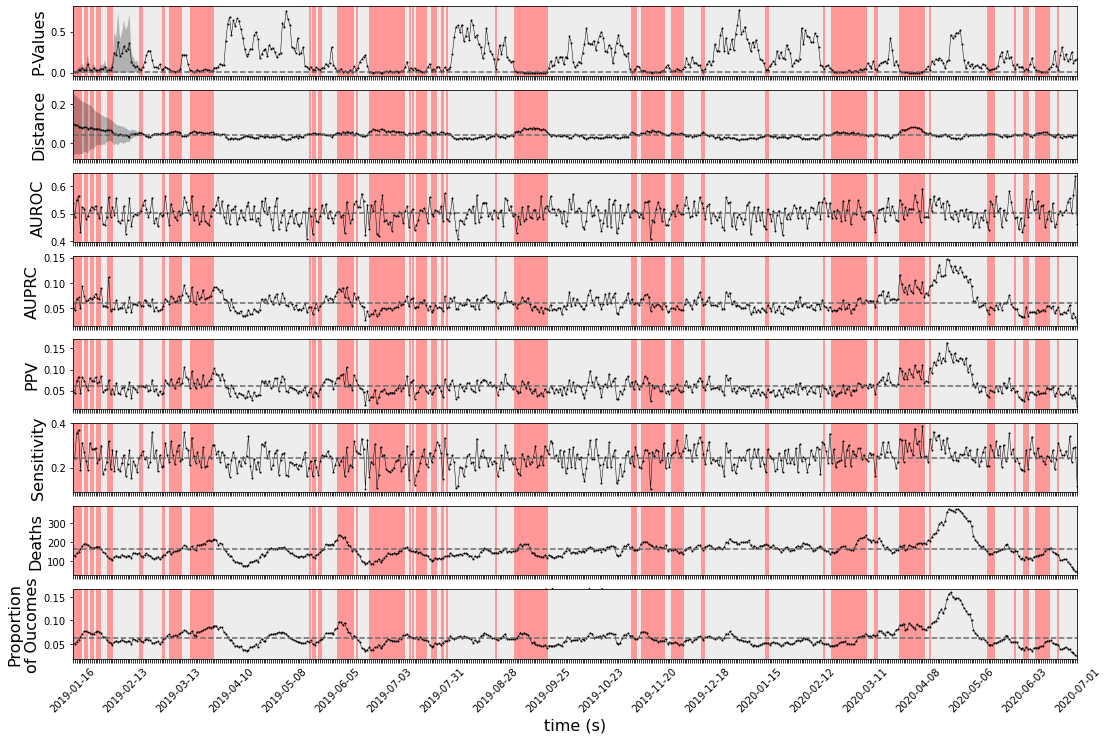

In [21]:
sig_drift = np.array(results["shift_detected"][START:])[np.newaxis]

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(18, 12))
cmap = ListedColormap(["lightgrey", "red"])
ax1.plot(
    results["timestamps"][START:],
    results["p_val"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax1.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax1.axhline(y=THRESHOLD, color="dimgrey", linestyle="--")
ax1.set_ylabel("P-Values", fontsize=16)
ax1.set_xticklabels([])
ax1.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["p_val"], results["p_val_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["p_val"], results["p_val_error"])], facecolor ='black', alpha = 0.25)
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax2.plot(
    results["timestamps"][START:],
    results["distance"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax2.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax2.set_ylabel("Distance", fontsize=16)
ax2.axhline(y=np.nanmean(results["distance"][START:]), color="dimgrey", linestyle="--")
ax2.set_xticklabels([])
ax2.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["distance"], results["distance_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["distance"], results["distance_error"])], facecolor ='black', alpha = 0.25)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax3.plot(
    results["timestamps"][START:],
    results["auroc"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax3.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax3.set_ylabel("AUROC", fontsize=16)
ax3.axhline(y=np.nanmean(results["auroc"][START:]), color="dimgrey", linestyle="--")
ax3.set_xticklabels([])
ax3.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["auroc"], results["auroc_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["auroc"], results["auroc_error"])], facecolor ='black', alpha = 0.25)
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax4.plot(
    results["timestamps"][START:],
    results["auprc"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax4.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax4.set_ylabel("AUPRC", fontsize=16)
ax4.axhline(y=np.nanmean(results["auprc"][START:]), color="dimgrey", linestyle="--")
ax4.set_xticklabels([])
ax4.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["auprc"], results["auprc_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["auprc"], results["auprc_error"])], facecolor ='black', alpha = 0.25)
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax5.plot(
    results["timestamps"][START:],
    results["prec1"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax5.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax5.set_ylabel("PPV", fontsize=16)
ax5.axhline(y=np.nanmean(results["prec1"][START:]), color="dimgrey", linestyle="--")
ax5.set_xticklabels([])
ax5.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["prec1"], results["prec1_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["prec1"], results["prec1_error"])], facecolor ='black', alpha = 0.25)
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax6.plot(
    results["timestamps"][START:],
    results["rec1"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax6.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax6.set_ylabel("Sensitivity", fontsize=16)
ax6.axhline(y=np.nanmean(results["rec1"][START:]), color="dimgrey", linestyle="--")
ax6.set_xticklabels([])
ax6.fill_between(results["timestamps"], 
                 [x1 - x2*2 for (x1, x2) in zip(results["rec1"], results["rec1_error"])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["rec1"], results["rec1_error"])], facecolor ='black', alpha = 0.25)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax7.plot(
    results["timestamps"][START:],
    results["n_outcome"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax7.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax7.set_ylabel("Deaths", fontsize=16)
ax7.set_xlabel("time (s)", fontsize=16)
ax7.axhline(y=np.nanmean(results["n_outcome"][START:]), color="dimgrey", linestyle="--")
ax7.set_xticklabels([])
ax7.pcolorfast(ax7.get_xlim(), ax7.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax8.plot(
    results["timestamps"][START:],
    results["outcome_prop"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax8.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax8.set_ylabel("Proportion\nof Oucomes", fontsize=16)
ax8.set_xlabel("time (s)", fontsize=16)
ax8.axhline(y=np.nanmean(results["outcome_prop"][START:]), color="dimgrey", linestyle="--")
ax8.tick_params(axis="x", labelrotation=45)
ax8.pcolorfast(ax8.get_xlim(), ax8.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

for index, label in enumerate(ax8.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()